In [1]:
import matplotlib.pyplot as plt
import numpy as np
import argosim
import argosim.antenna_utils
import argosim.plot_utils

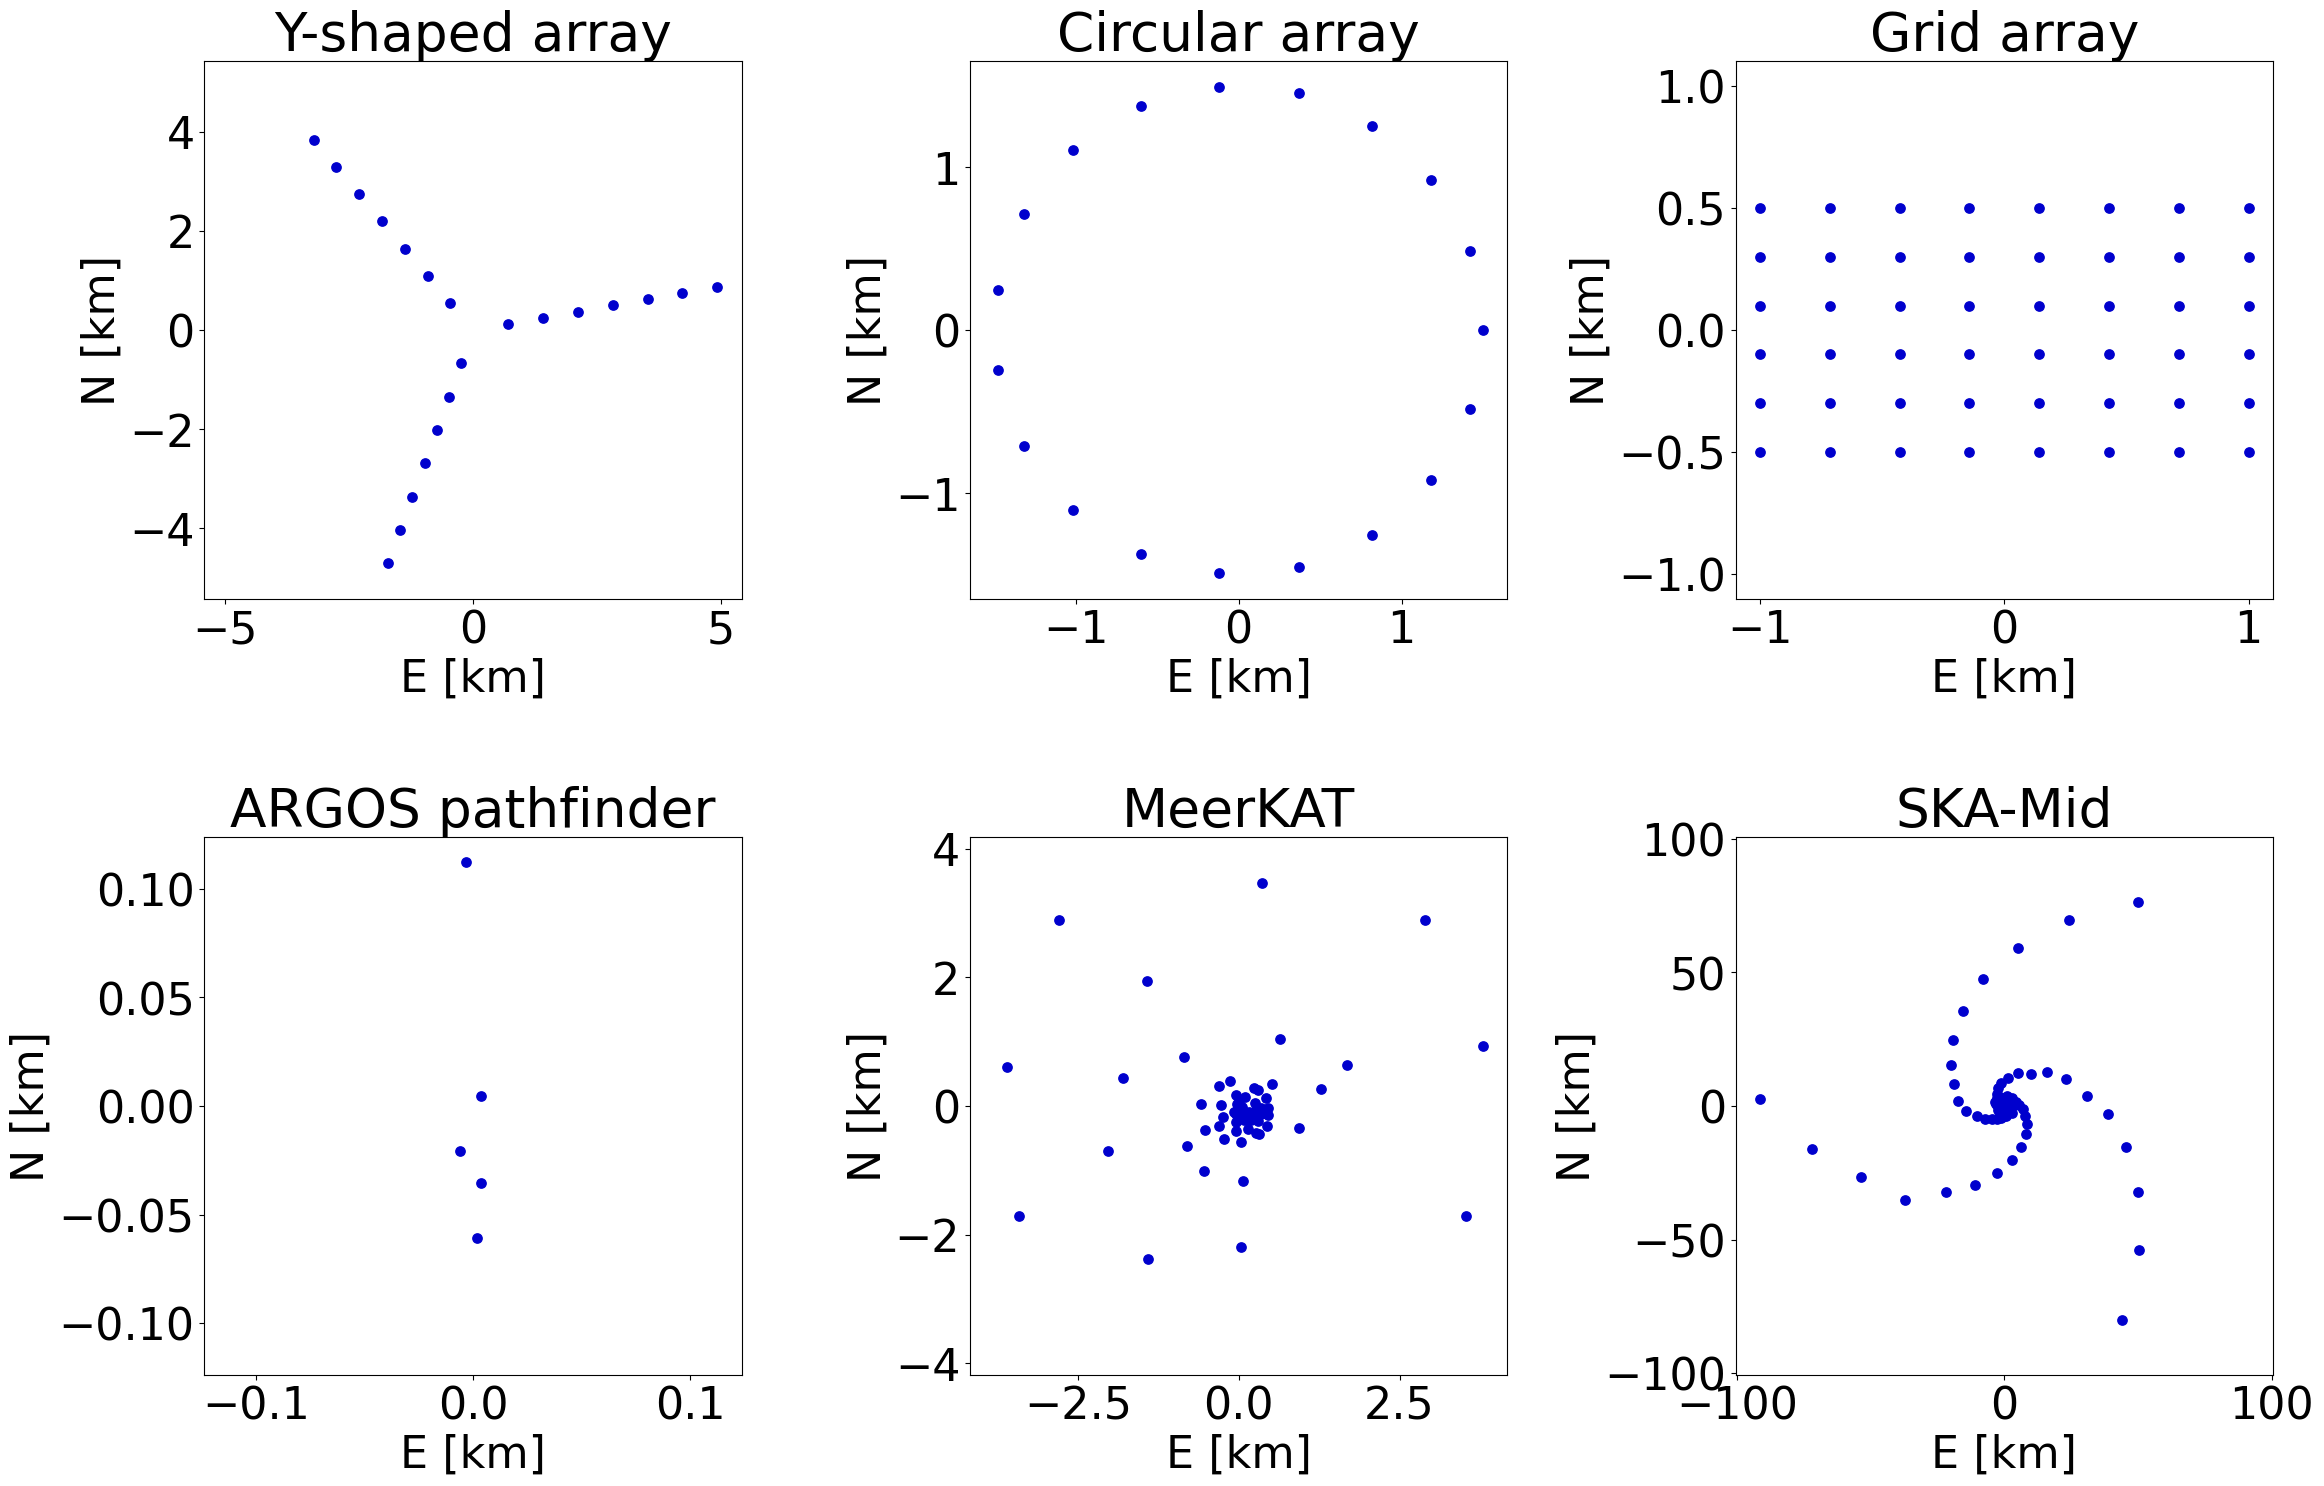

In [ ]:

# increase font size
plt.rcParams.update({'font.size': 32})

y_arr = argosim.antenna_utils.y_antenna_arr(7, r=5e3, alpha=10)
circ_arr = argosim.antenna_utils.circular_antenna_arr(19, r=1.5e3)
grid_arr = argosim.antenna_utils.uni_antenna_array(8, 6, E_lim=2e3, N_lim=1e3)

argos_arr = argosim.antenna_utils.load_antenna_enu_txt('../configs/arrays/argos_pathfinder.enu.txt')
meerkat_arr = argosim.antenna_utils.load_antenna_enu_txt('../configs/arrays/meerkat.enu.txt')
skamid_arr = argosim.antenna_utils.load_antenna_enu_txt('../configs/arrays/skamid197.enu.txt')

fig, ax = plt.subplots(2, 3, figsize=(24, 16))

argosim.plot_utils.plot_antenna_arr(y_arr,ax[0,0], fig ,title='Y-shaped array', antenna_idx=False, s=45)
argosim.plot_utils.plot_antenna_arr(circ_arr, ax[0,1], fig, title='Circular array', antenna_idx=False, s=45)
argosim.plot_utils.plot_antenna_arr(grid_arr, ax[0,2], fig, title='Grid array', antenna_idx=False, s=45)

argosim.plot_utils.plot_antenna_arr(argos_arr, ax[1,0], fig, title='ARGOS pathfinder', antenna_idx=False, s=45)
argosim.plot_utils.plot_antenna_arr(meerkat_arr, ax[1,1], fig, title='MeerKAT', antenna_idx=False, s=45)
argosim.plot_utils.plot_antenna_arr(skamid_arr, ax[1,2], fig, title='SKA-Mid', antenna_idx=False, s=45)

plt.tight_layout()
# plt.savefig('../figures/antenna_configs.pdf')
plt.show()

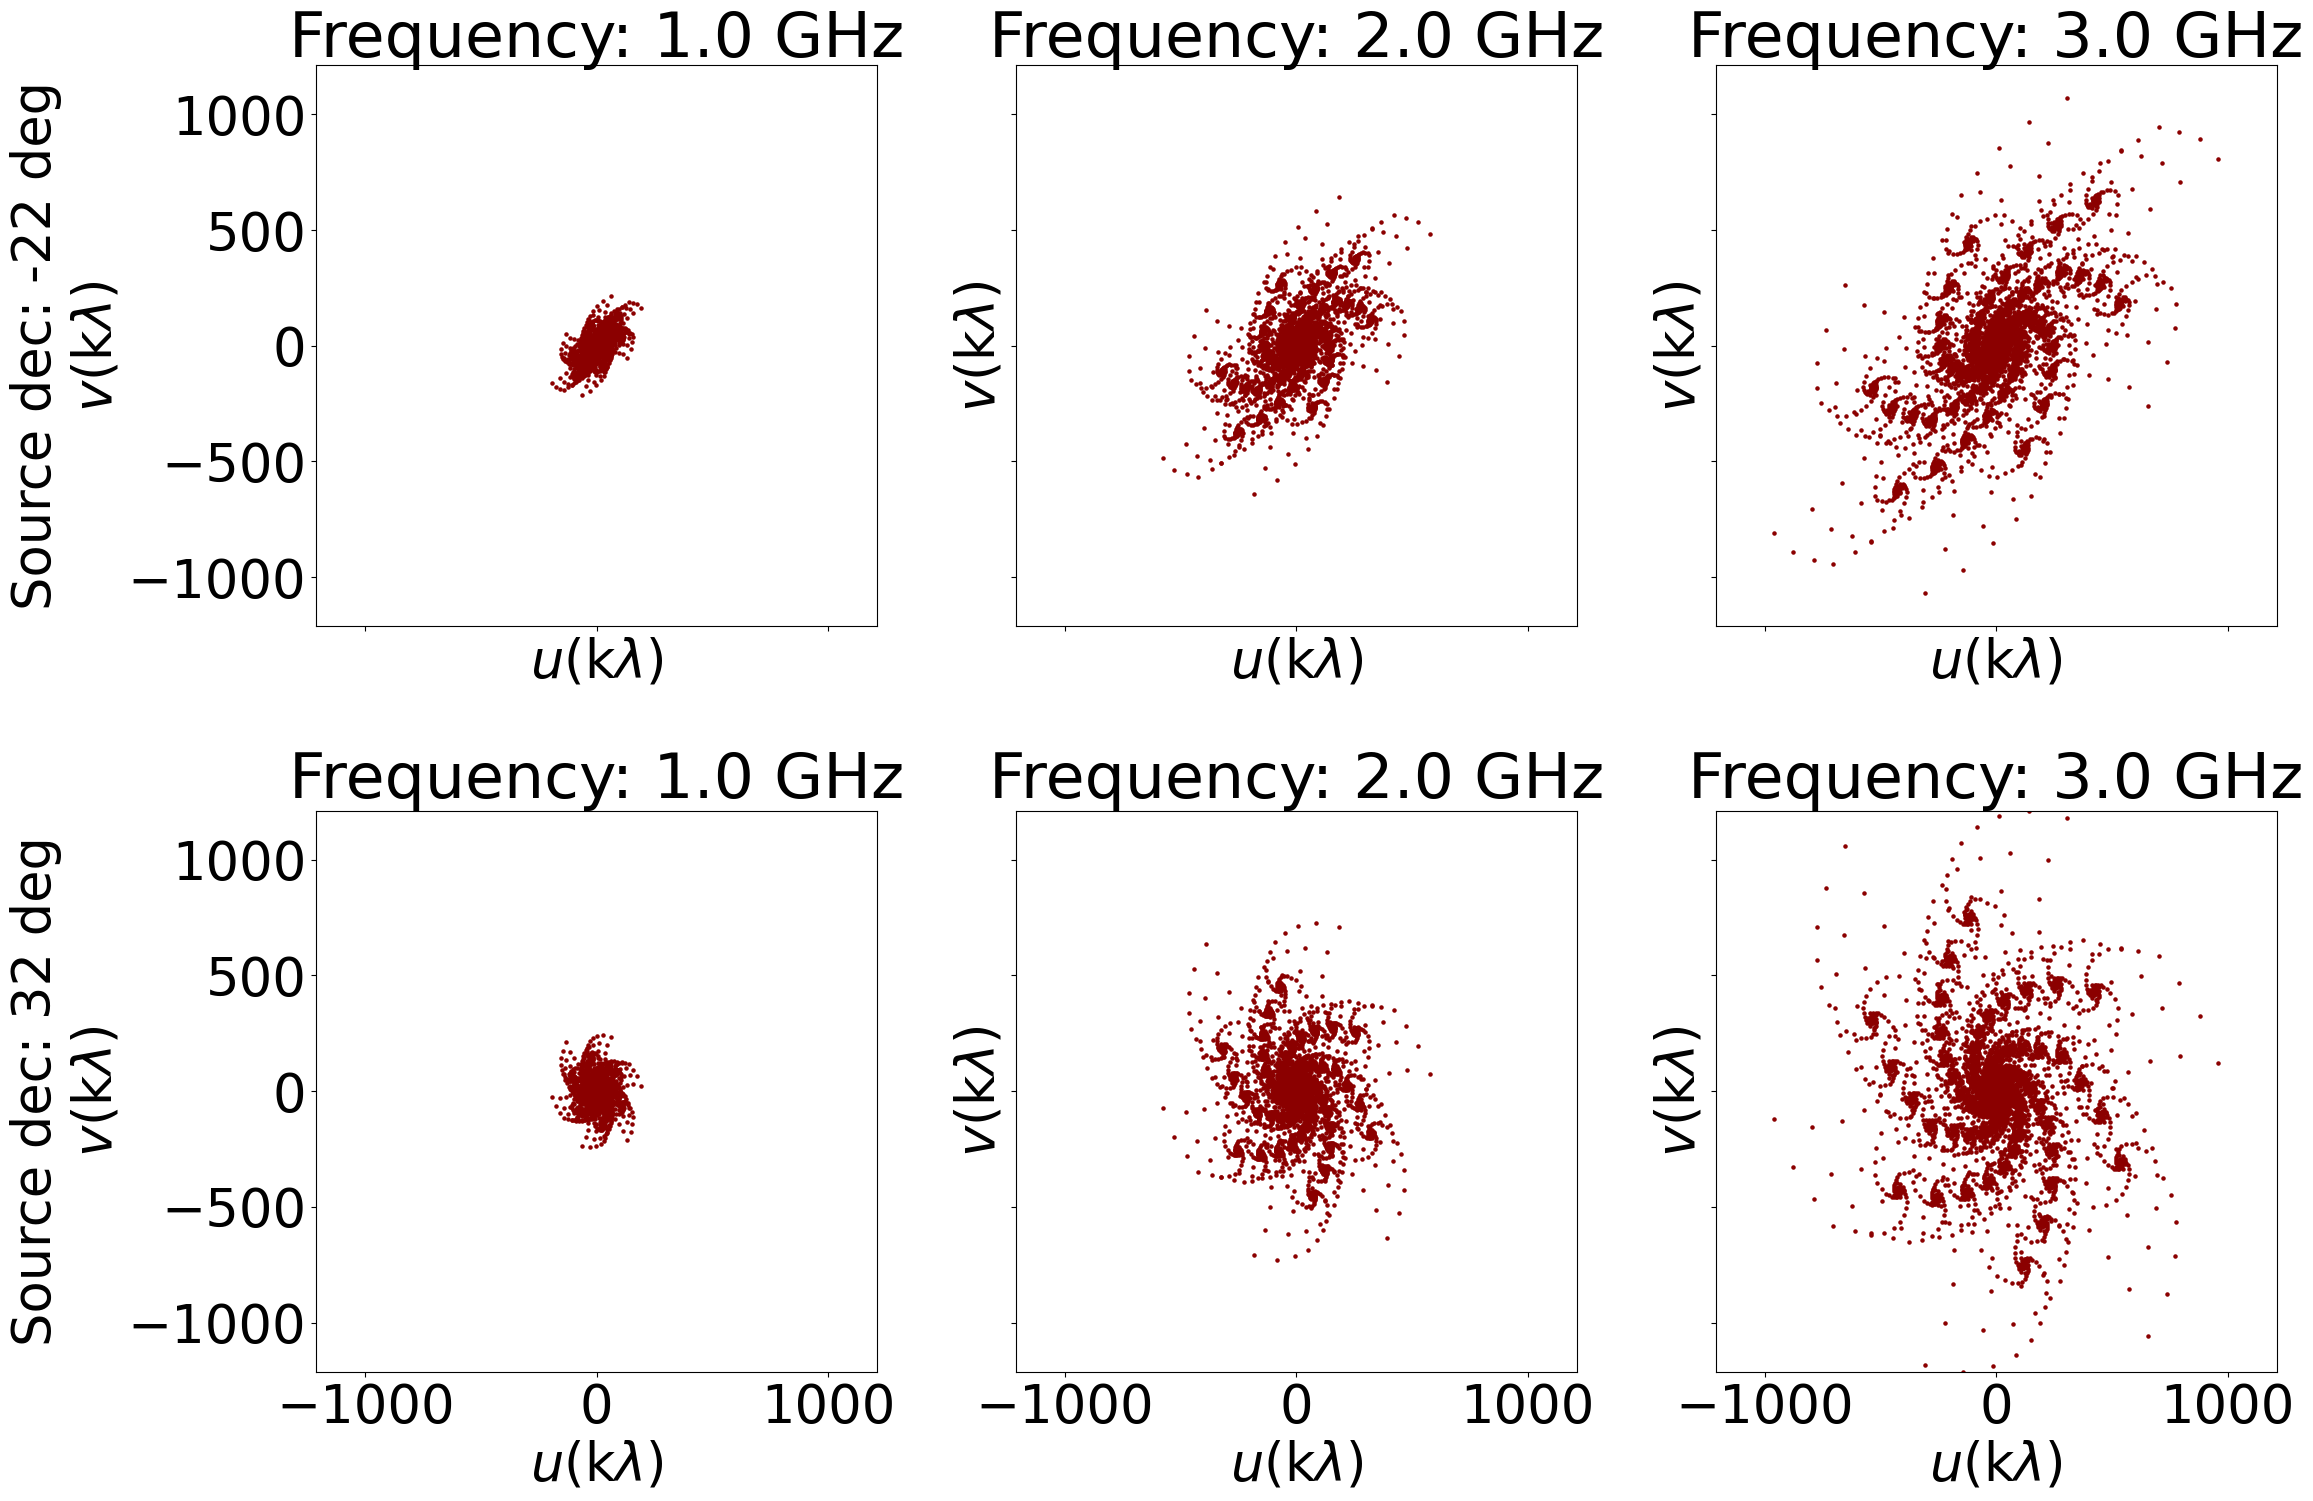

In [ ]:
b_enu_ska = argosim.antenna_utils.get_baselines(skamid_arr)

f = [1.0e9, 2.0e9, 3.0e9]

fig, (ax_0,ax_1) = plt.subplots(2,3, figsize=(24, 16), sharex=True, sharey=True)
for i in range(3):
    track_0, _ = argosim.antenna_utils.uv_track_multiband(
        b_ENU=b_enu_ska,
        lat=17./180*np.pi,
        dec=-22./180*np.pi,
        track_time=1.,
        t_0=-3.,
        n_times=1,
        f=f[i],
        df=1.0e9,
        n_freqs=1,
        multi_band=False
    )
    track_1, _ = argosim.antenna_utils.uv_track_multiband(
        b_ENU=b_enu_ska,
        lat=17./180*np.pi,
        dec=32./180*np.pi,
        track_time=1.,
        t_0=-3.,
        n_times=1,
        f=f[i],
        df=1.0e9,
        n_freqs=1,
        multi_band=False
    )
    argosim.plot_utils.plot_baselines(track_0, ax_0[i], fig)
    ax_0[i].set_title(f"Frequency: {f[i]/1e9} GHz")
    argosim.plot_utils.plot_baselines(track_1, ax_1[i], fig)
    ax_1[i].set_title(f"Frequency: {f[i]/1e9} GHz")
ax_0[0].set_ylabel("Source dec: -22 deg\n"+r"$v$(k$\lambda$)")
ax_1[0].set_ylabel("Source dec: 32 deg\n"+r"$v$(k$\lambda$)")

plt.tight_layout()
# plt.savefig('../figures/baselines_skamid.pdf')
plt.show()



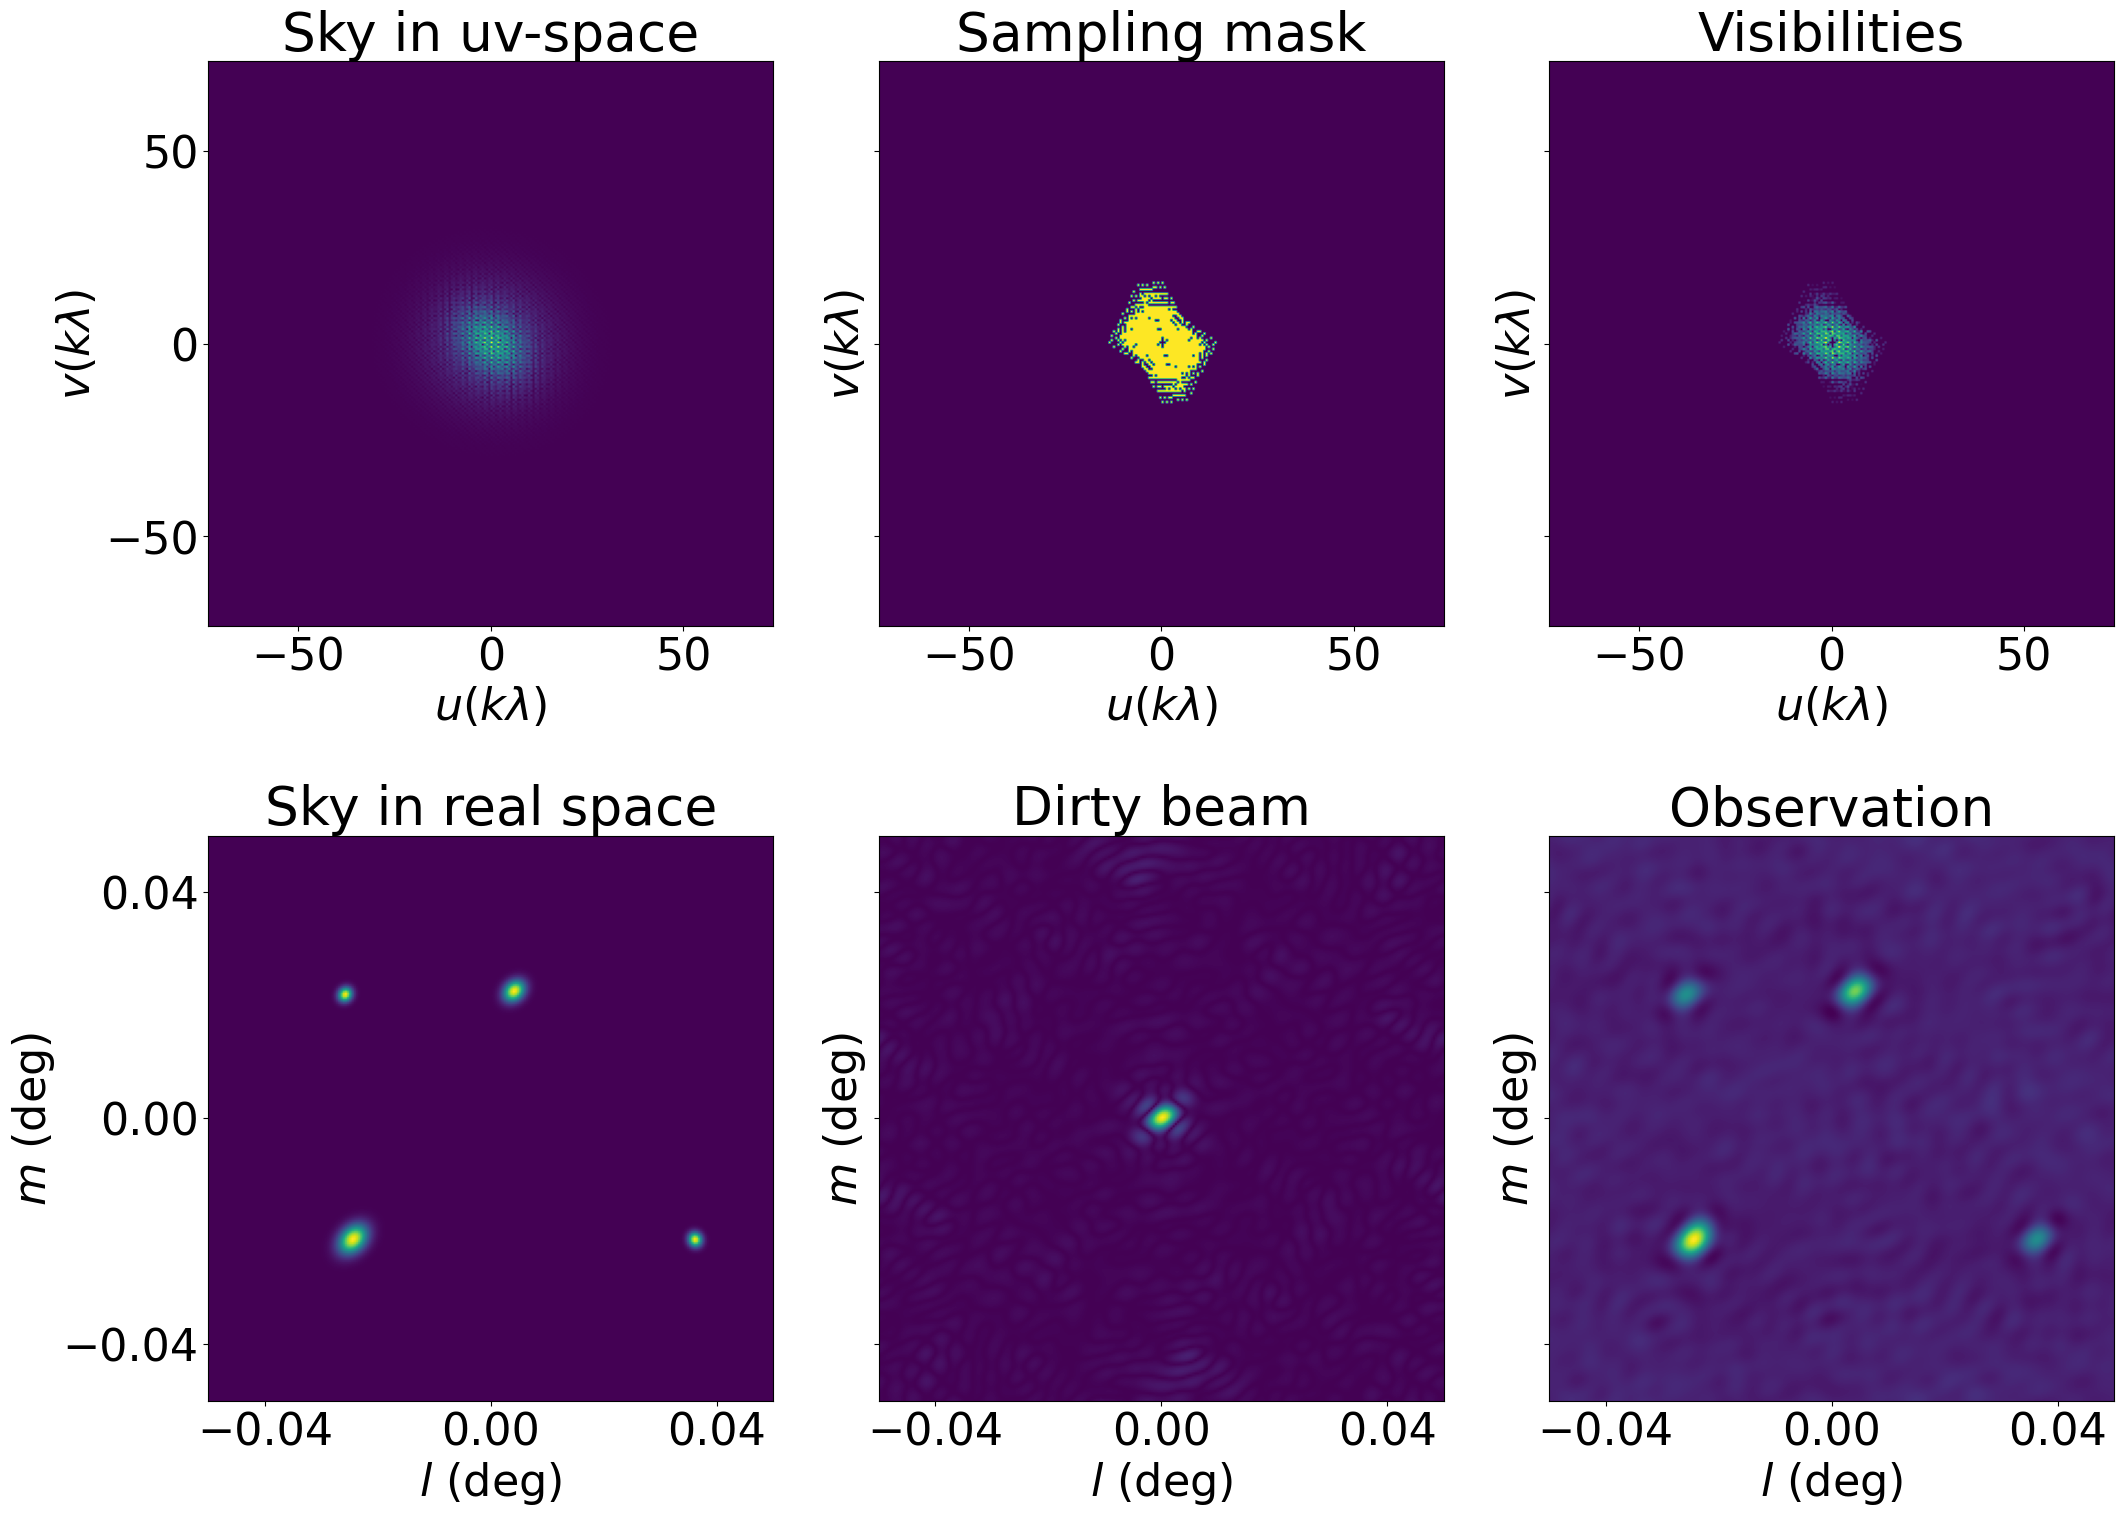

In [ ]:
import argosim.data_utils
import argosim.imaging_utils
import argosim.plot_utils

plt.rcParams.update({'font.size': 32})

b_enu_pathfinder = argosim.antenna_utils.get_baselines(grid_arr)
track_pathfinder, _ = argosim.antenna_utils.uv_track_multiband(
        b_ENU=b_enu_pathfinder,
        lat=34./180*np.pi,
        dec=34./180*np.pi,
        track_time=1.5,
        t_0=-5.,
        n_times=6,
        f=2.0e9,
        df=1e9,
        n_freqs=3,
        multi_band=False
    )
fov_size = (0.1, 0.1)  # in radians
sky = argosim.data_utils.n_source_sky((256, 256), fov=.1, deg_size_list=[0.002, 0.003, 0.002, 0.004], source_intensity_list=[.25]*4, 
                                      seed=29)
sky_f = argosim.imaging_utils.sky2uv(sky)
mask_uv, _ = argosim.imaging_utils.grid_uv_samples(track_pathfinder, (256, 256), (.1, .1))
beam = argosim.imaging_utils.uv2sky(mask_uv)
obs_uv = argosim.imaging_utils.compute_visibilities_grid(sky_f, mask_uv)
obs = argosim.imaging_utils.uv2sky(obs_uv)

fig, ax = plt.subplots(2,3, figsize=(22, 16), sharey='row')

max_u = (180 / np.pi) * sky_f.shape[0] / (2 * fov_size[0]) / 1000
max_v = (180 / np.pi) * sky_f.shape[1] / (2 * fov_size[1]) / 1000

ax[0,0].imshow(np.abs(sky_f),  extent=[-max_u, max_u, -max_v, max_v], origin="lower")
ax[0,0].set_xlabel(r"$u(k\lambda$)")
ax[0,0].set_ylabel(r"$v(k\lambda$)")
ax[0,0].set_title("Sky in uv-space")
ax[0,0].set_yticks([-50, 0, 50])
ax[0,1].imshow(np.abs(mask_uv),  extent=[-max_u, max_u, -max_v, max_v], origin="lower")
ax[0,1].set_xlabel(r"$u(k\lambda$)")
ax[0,1].set_ylabel(r"$v(k\lambda$)")
ax[0,1].set_title("Sampling mask")
ax[0,2].imshow(np.abs(obs_uv),  extent=[-max_u, max_u, -max_v, max_v], origin="lower")
ax[0,2].set_xlabel(r"$u(k\lambda$)")
ax[0,2].set_ylabel(r"$v(k\lambda$)")
ax[0,2].set_title("Visibilities")

ax[1,0].imshow(np.abs(sky),extent=[-fov_size[0] / 2, fov_size[0] / 2, -fov_size[1] / 2, fov_size[1] / 2], origin="lower")
ax[1,0].set_xlabel(r"$l$ (deg)")
ax[1,0].set_ylabel(r"$m$ (deg)")
ax[1,0].set_title("Sky in real space")
ax[1,0].set_yticks([-.04, 0, 0.04])
ax[1,0].set_xticks([-.04, 0, 0.04])
ax[1,1].imshow(np.abs(beam),extent=[-fov_size[0] / 2, fov_size[0] / 2, -fov_size[1] / 2, fov_size[1] / 2], origin="lower")
ax[1,1].set_xlabel(r"$l$ (deg)")
ax[1,1].set_ylabel(r"$m$ (deg)")
ax[1,1].set_title("Dirty beam")
ax[1,1].set_xticks([-.04, 0, 0.04])
ax[1,2].imshow(obs,extent=[-fov_size[0] / 2, fov_size[0] / 2, -fov_size[1] / 2, fov_size[1] / 2], origin="lower")
ax[1,2].set_xlabel(r"$l$ (deg)")
ax[1,2].set_ylabel(r"$m$ (deg)")
ax[1,2].set_title("Observation")
ax[1,2].set_xticks([-.04, 0, 0.04])
plt.tight_layout()
# plt.savefig('../figures/sky_beam_obs.pdf')
plt.show()

# Beam metrics

/Users/ec270266/Documents/Phd/Argos/repos/argosim/src/argosim/imaging_utils.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  uv_mask = jnp.zeros(sky_uv_shape, dtype=jnp.complex128)


{'center': (64.0, 64.0), 'width': 24.878001413739014, 'height': 8.906900935494585, 'angle_deg': -37.92369105410229, 'eccentricity': 0.9337127018350242}
FWHM = 0.039 deg
FWHM = 0.014 deg


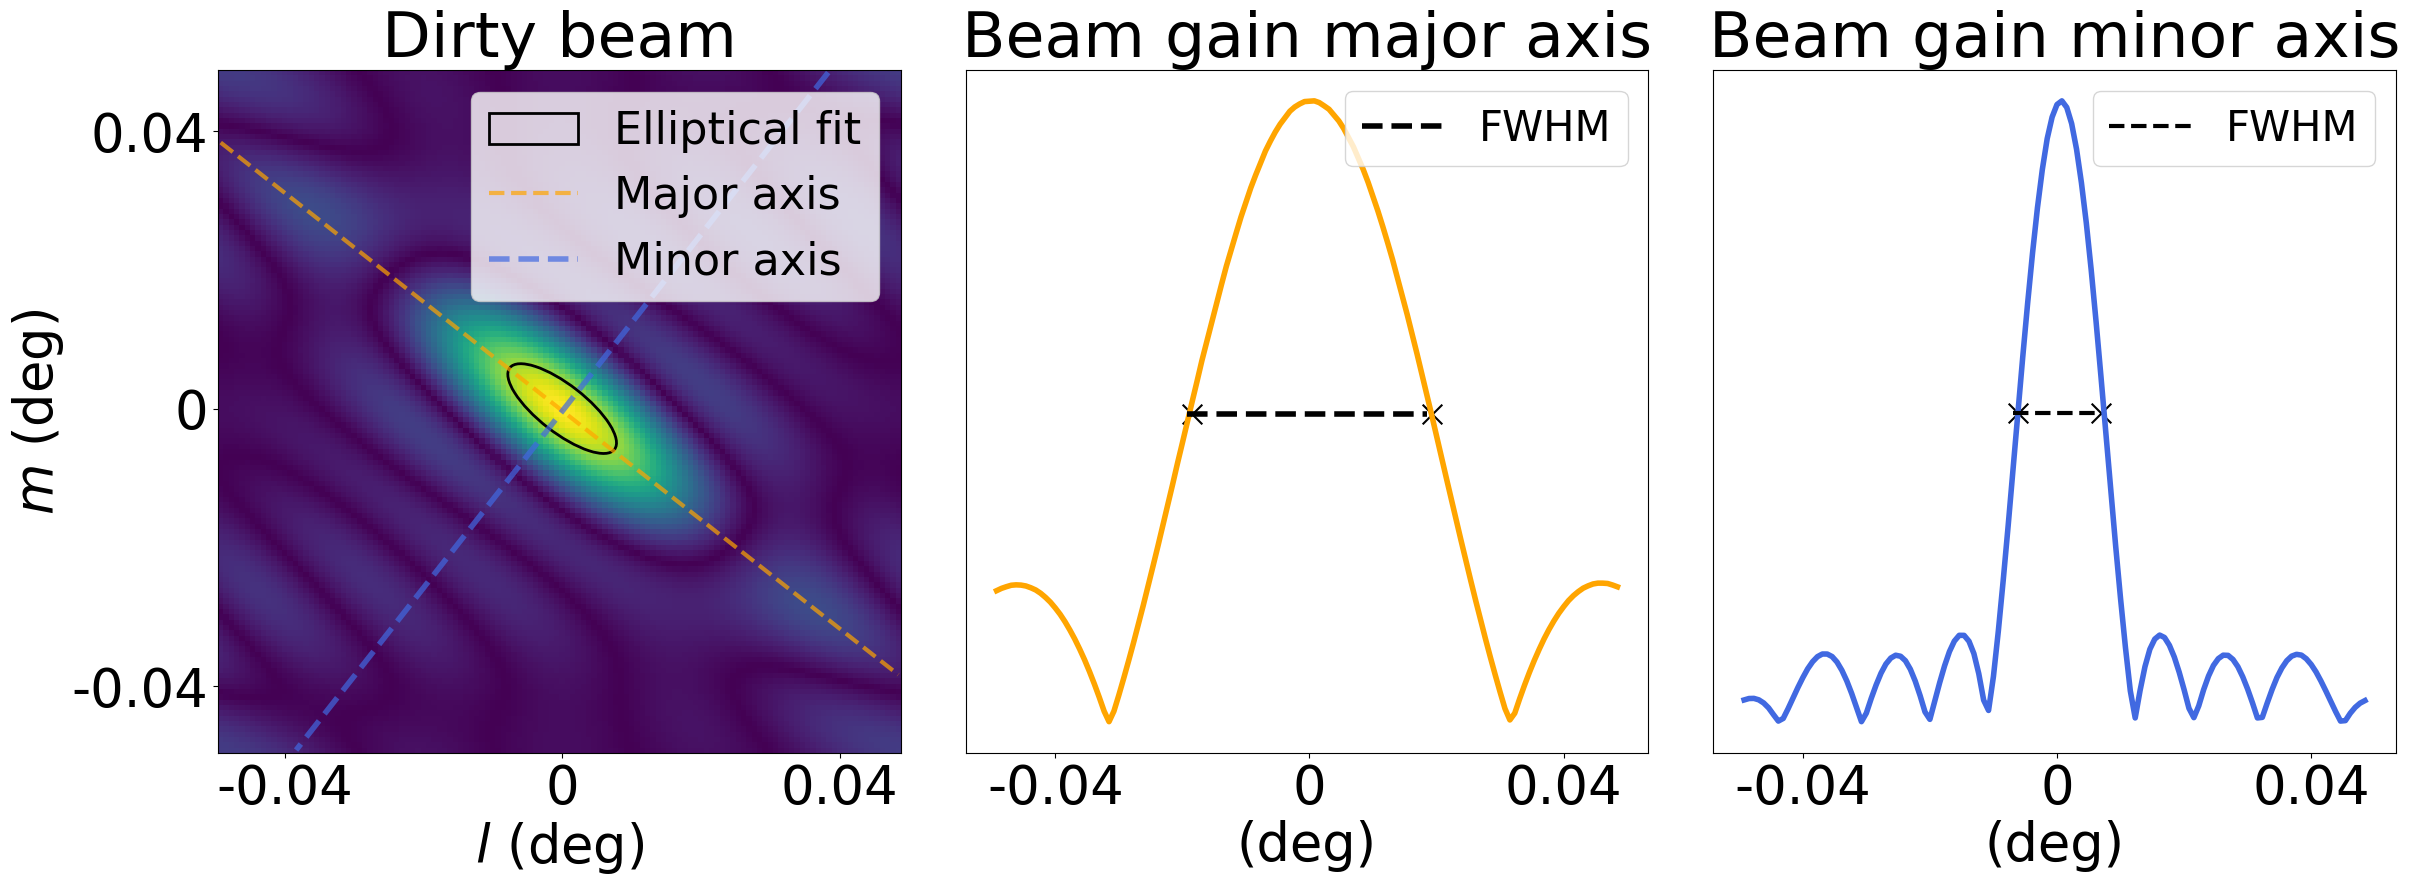

In [ ]:
import argosim.antenna_utils
import argosim.imaging_utils
import argosim.metrics_utils
import argosim.plot_utils
from matplotlib.patches import Ellipse
from skimage.transform import rotate

plt.rcParams.update({'font.size': 38})

fov_size = (0.1, 0.1)  # in radians
Npx = 128  # number of pixels in each dimension

# arr = argosim.antenna_utils.random_antenna_arr(12, E_lim=400.0, N_lim=300.0, U_lim=0.0, seed=22)
arr =  argosim.antenna_utils.circular_antenna_arr(14, r=150.)
b_enu = argosim.antenna_utils.get_baselines(arr)

track_, _ = argosim.antenna_utils.uv_track_multiband(
        b_ENU=b_enu,
        lat=-31./180*np.pi,
        dec=12./180*np.pi,
        track_time=1.5,
        t_0=4.,
        n_times=6,
        f=2.0e9,
        df=1e9,
        n_freqs=3,
        multi_band=False
    )

mask_uv_, _ = argosim.imaging_utils.grid_uv_samples(track_, (Npx, Npx), fov_size)
beam = np.abs(argosim.imaging_utils.uv2sky(mask_uv_))
# argosim.plot_utils.plot_sky(np.abs(beam), fov_size=fov_size)
fit_result = argosim.metrics_utils.fit_elliptical_beam(beam)
print(fit_result)

ellipse = Ellipse(
        xy=fit_result["center"],
        width=fit_result["width"],
        height=fit_result["height"],
        angle=fit_result["angle_deg"],
        edgecolor="k",
        facecolor="none",
        lw=2,
        label="Elliptical fit",
    )

beam_rotated = rotate(beam, fit_result["angle_deg"], resize=True)
semi_major_beam = beam_rotated[beam_rotated.shape[0]//2,
                               beam_rotated.shape[0]//2-Npx//2:beam_rotated.shape[0]//2+Npx//2]
semi_minor_beam = beam_rotated[beam_rotated.shape[0]//2-Npx//2:beam_rotated.shape[0]//2+Npx//2,
                               beam_rotated.shape[1]//2]
# plt.plot(semi_major_beam, label="Semi-major axis")
# plt.plot(semi_minor_beam, label="Semi-minor axis")
# plt.imshow(np.abs(beam_rotated), origin="lower")
# 

fig, ax = plt.subplots(1,3, figsize=(25, 10))
# argosim.plot_utils.plot_sky(beam, fov_size=fov_size, ax=ax[0], fig=fig, title="Dirty beam")
ax[0].imshow(beam, origin="lower")#, extent=[-fov_size[0] / 2, fov_size[0] / 2, -fov_size[1] / 2, fov_size[1] / 2])
ax[0].set_yticks([Npx//10, Npx//2, Npx-Npx//10],[-fov_size[0]*2/5, 0, fov_size[0]*2/5])
ax[0].set_xticks([Npx//10, Npx//2, Npx-Npx//10],[-fov_size[0]*2/5, 0, fov_size[0]*2/5])
ax[0].set_xlabel(r"$l$ (deg)")
ax[0].set_ylabel(r"$m$ (deg)")

ax[0].add_patch(ellipse)
# Plot the semi-major and semi-minor axes as lines through the center of the ellipse
ax[0].plot(
    [0,Npx-1],
    [Npx//2-Npx//2*np.tan(np.radians(fit_result["angle_deg"])),Npx//2+Npx//2*np.tan(np.radians(fit_result["angle_deg"]))],
    color="orange",
    alpha=0.7,
    lw=3,
    label="Major axis",
    linestyle='--'
)
ax[0].plot(
    [Npx//2-Npx//2*np.tan(np.radians(fit_result["angle_deg"])),Npx//2+Npx//2*np.tan(np.radians(fit_result["angle_deg"]))],
    [Npx-1,0],
    color="royalblue",
    alpha=0.7,
    lw=4,
    label="Minor axis",
    linestyle='--'
)
ax[0].set_title("Dirty beam")
ax[0].legend(loc="upper right", fontsize=32)

ax[1].plot(semi_major_beam, color="orange", lw=4)
ax[1].set_title("Beam gain major axis")
ax[1].set_yticks([])
ax[1].set_box_aspect(1)
ax[1].set_xticks([Npx//10, Npx//2, Npx-Npx//10],[-fov_size[0]*2/5, 0, fov_size[0]*2/5])
ax[1].set_xlabel("(deg)")
ax[1].plot(
    [int(Npx//2-fit_result["width"]), int(Npx//2+fit_result["width"])],
    [np.max(semi_major_beam)/2, np.max(semi_major_beam)/2],
    color="black",
    linestyle='--',
    lw=4,
    label="FWHM"
)
ax[1].scatter(
    [int(Npx//2-fit_result["width"]+1), int(Npx//2+fit_result["width"]+1)],
    [np.max(semi_major_beam)/2, np.max(semi_major_beam)/2],
    color="black",
    marker="x",
    s=200
)
ax[1].legend(loc="upper right", fontsize=30)
# ax[1].annotate(
#     "FWHM = {:.2f} deg".format(fit_result["width"]/128*fov_size[0]*2),
#     xy=(0.5, 0.44),
#     xycoords="axes fraction",
#     ha="center",
#     va="center",
#     fontsize=32,
#     color="dimgray"
# )
print("FWHM = {:.3f} deg".format(fit_result["width"]/Npx*fov_size[0]*2))

ax[2].plot(semi_minor_beam, color="royalblue", lw=4)
ax[2].set_title("Beam gain minor axis")
ax[2].set_yticks([])
ax[2].set_box_aspect(1)
ax[2].set_xticks([Npx//10, Npx//2, Npx-Npx//10],[-fov_size[0]*2/5, 0, fov_size[0]*2/5])
ax[2].set_xlabel("(deg)")
ax[2].plot(
    [int(Npx//2-fit_result["height"]), int(Npx//2+fit_result["height"])],
    [np.max(semi_minor_beam)/2, np.max(semi_minor_beam)/2],
    color="black",
    linestyle='--',
    lw=3,
    label="FWHM"
)
ax[2].scatter(
    [int(Npx//2-fit_result["height"]+1), int(Npx//2+fit_result["height"]+1)],
    [np.max(semi_minor_beam)/2, np.max(semi_minor_beam)/2],
    color="black",
    marker="x",
    s=200
)
ax[2].legend(loc="upper right", fontsize=30)
# ax[2].annotate(
#     "FWHM = {:.2f} deg".format(fit_result["height"]/128*fov_size[1]*2),
#     xy=(0.52, 0.54),
#     xycoords="axes fraction",
#     ha="center",
#     va="center",
#     fontsize=32,
#     color="black"
# )
print("FWHM = {:.3f} deg".format(fit_result["height"]/128*fov_size[1]*2))
plt.tight_layout()
# plt.savefig('../figures/beam_metrics.pdf')
plt.show()

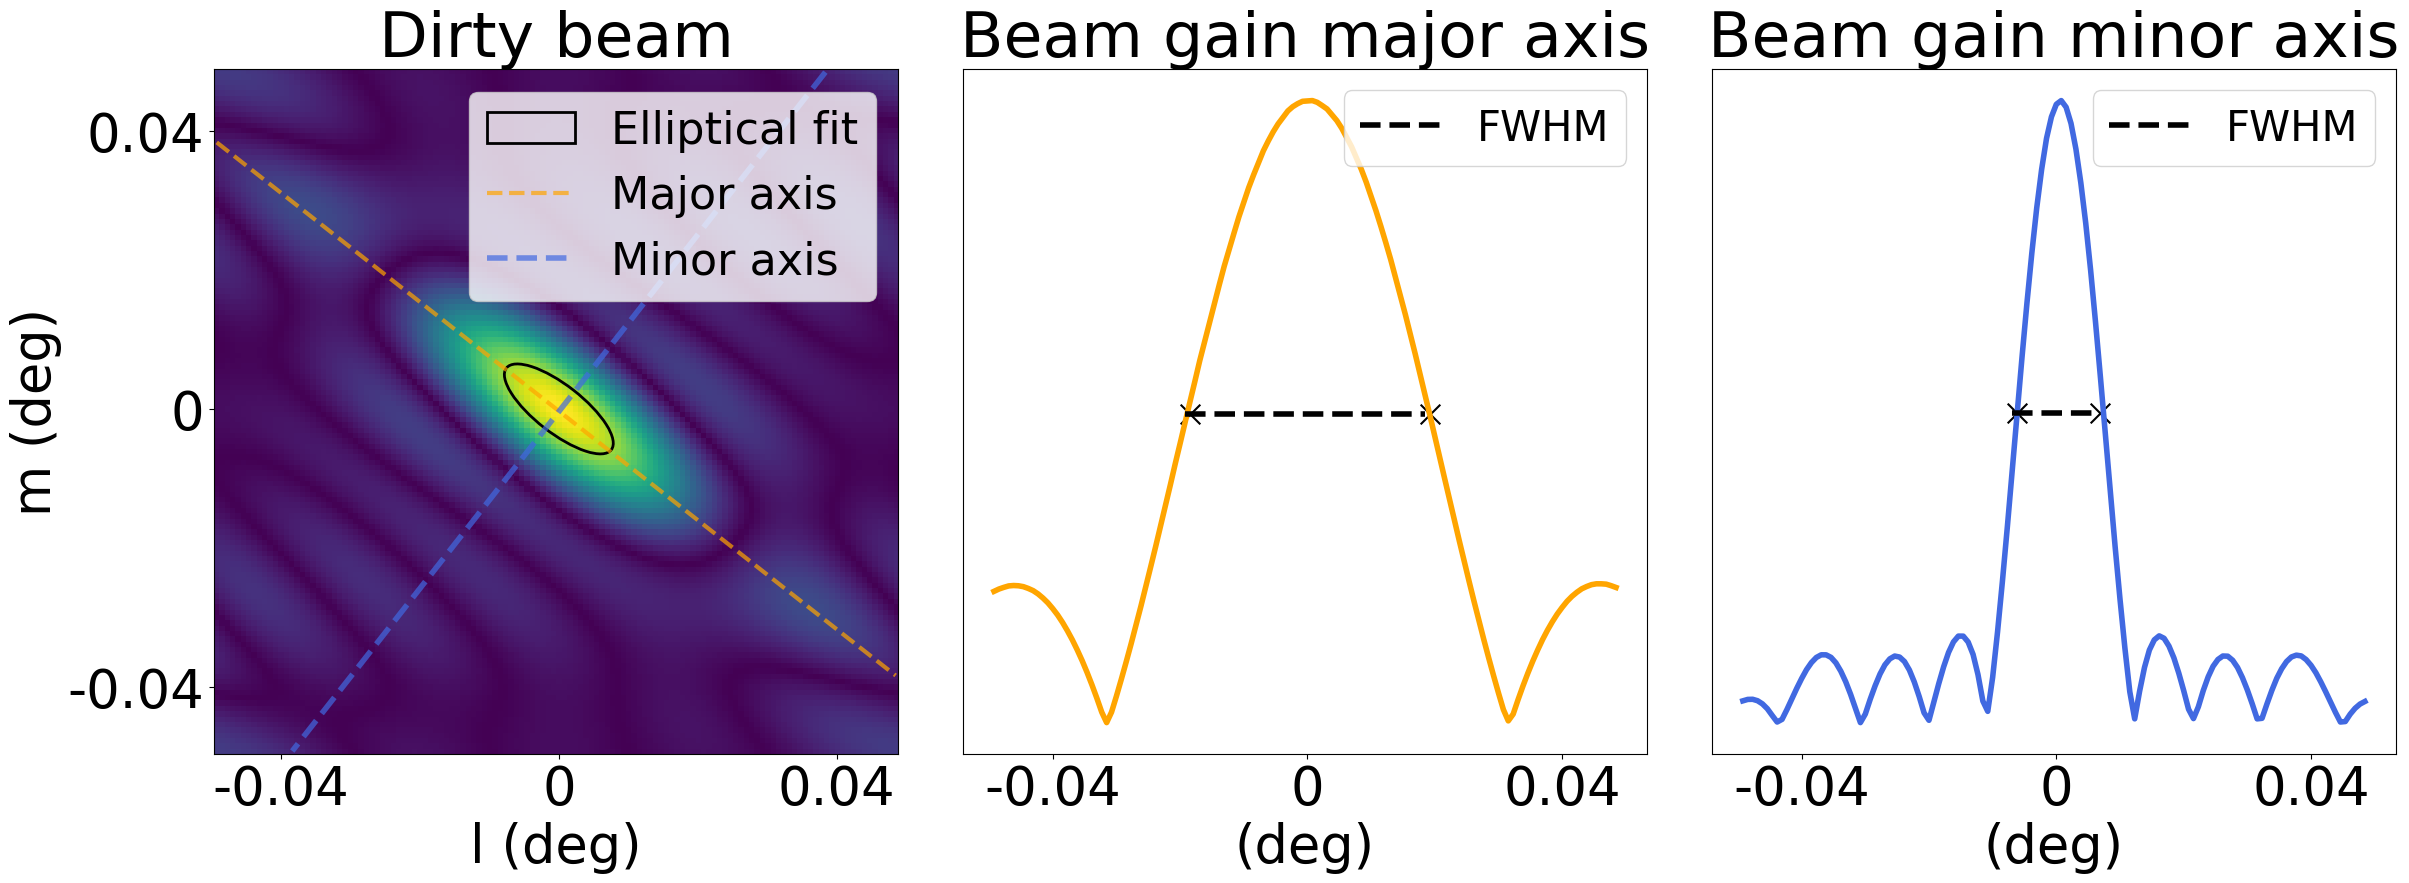

In [20]:
argosim.plot_utils.plot_beam_and_fit(beam, fov_size)